In [1]:
import sys
sys.path.append('/fsx/matzeni/duck')

In [2]:
import torch
import h5py
import json
from pathlib import Path
import pickle
from tqdm import tqdm
import logging
from transformers import AutoTokenizer
from typing import Any, Dict, List, Optional, Tuple
import copy
from einops import rearrange, repeat
import numpy as np
from duck.box_tensors import BoxTensor
from duck.task.duck_entity_disambiguation import Duck
from hydra import compose, initialize
import hydra
from duck.common.utils import seed_prg
import collections
import logging
import math
from duck.box_tensors.functional import cat_box
from matplotlib import pyplot as plt
from duck.common.utils import cartesian_to_spherical
from einops import repeat, rearrange
logger = logging.getLogger()

In [3]:
initialize(config_path="../conf", version_base=None)

hydra.initialize()

In [4]:
config = compose(
    config_name="duck",
    overrides=[]
)

In [5]:
ckpt_path = "/checkpoints/matzeni/duck/checkpoints/duck_spherical_epoch=0_val_f1=0.579.ckpt"
duck = Duck.load_from_checkpoint(ckpt_path).eval().cuda()

In [6]:
datamodule = duck.data

In [7]:
def batch_to_cuda(batch):
    if isinstance(batch, torch.Tensor):
        return batch.cuda()
    if isinstance(batch, collections.abc.Mapping):
        return {k: batch_to_cuda(v) for k, v in batch.items()}
    if isinstance(batch, str):
        return batch
    if isinstance(batch, collections.abc.Sequence):
        return [batch_to_cuda(v) for v in batch]
    return batch

In [8]:
seed_prg(ngpus=config.trainer.devices)
train_data = datamodule.train_dataloader()
train_data_iterator = iter(train_data)

In [9]:
duck.eval()
torch.set_grad_enabled(False)

In [10]:
entity_boxes = []
entities = []
torch.cuda.empty_cache()
max_iter = 100
i = 1
for batch in tqdm(train_data):
    i = i + 1
    batch = batch_to_cuda(batch)
    representations = duck(batch)
    mask = batch["relation_ids"]["attention_mask"].bool()
    entity_boxes.append(
        representations["entity_boxes"][mask]
    )
    entities.append(
        representations["entities"]
    )
    if i >= max_iter:
        break

 17%|█▋        | 98/577 [00:13<01:08,  7.02it/s]


In [11]:
entity_boxes = cat_box(entity_boxes, dim=0)
_, entities = cartesian_to_spherical(torch.cat(entities, dim=0))

In [12]:
entities = entities[..., :entity_boxes.box_shape[-1]]

In [13]:
sizes = entity_boxes.right - entity_boxes.left

In [14]:
entities

tensor([[1.5732, 1.5792, 1.5795,  ..., 1.5240, 1.5744, 1.5894],
        [1.5655, 1.5578, 1.5614,  ..., 1.5354, 1.6082, 1.5837],
        [1.5675, 1.5485, 1.5848,  ..., 1.5136, 1.5952, 1.5594],
        ...,
        [1.5621, 1.5341, 1.5661,  ..., 1.5302, 1.5987, 1.5978],
        [1.5958, 1.5482, 1.5838,  ..., 1.5446, 1.6654, 1.5692],
        [1.5767, 1.5315, 1.5674,  ..., 1.5440, 1.6520, 1.5535]],
       device='cuda:0')

In [15]:
# plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#dbdbdb"

In [16]:
entities = repeat(entities, "b d -> (a b) d", a=25)

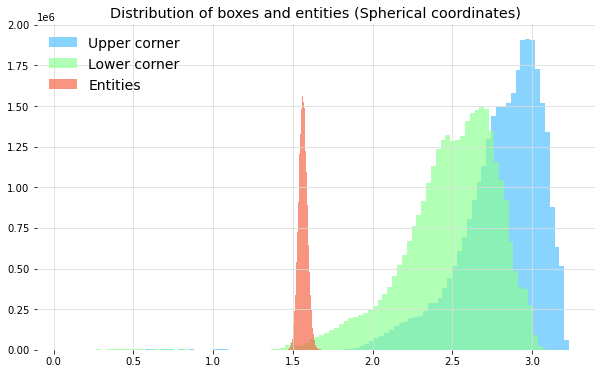

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(entity_boxes.right.view(-1).cpu().numpy(), density=False, color="#4fbfffaa", bins=100, label="Upper corner")
plt.hist(entity_boxes.left.view(-1).cpu().numpy(), density=False, color="#8cff92aa", bins=100, label="Lower corner")
plt.hist(entities.contiguous().view(-1).cpu().numpy(), density=False, color="#f56042aa", bins=100, label="Entities")
plt.title("Distribution of boxes and entities (Spherical coordinates)")
plt.legend(fontsize=14, frameon=False)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(sizes.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
plt.title("Distribution of the size of the boxes (Spherical coordinates)")
plt.show()

In [ ]:
entities.size(), entity_boxes.left.size()

In [ ]:
norms = torch.linalg.vector_norm(entities, dim=-1, ord=2)
plt.figure(figsize=(10, 6))
plt.hist(norms.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
# plt.text(16.62, 70, f'$\mu={torch.mean(norms):.2f}$', fontsize=16)
# plt.text(16.62, 57, f'$\sigma={torch.std(norms):.4f}$', fontsize=16)
plt.title('Distribution of embedding norms')
plt.show()

In [ ]:
mean = entities.mean(dim=0)
mean_direction = mean / torch.linalg.vector_norm(mean, ord=2)
import torch.nn.functional as f 
normalised_embeddings = entities / torch.linalg.vector_norm(entities, ord=2.0, dim=-1).unsqueeze(-1)
exp_mean_dir = mean_direction.expand(entities.shape[0], -1)
all_cosine_nonsummed = normalised_embeddings * exp_mean_dir
all_cosine = torch.sum(all_cosine_nonsummed, dim=-1)

In [ ]:
torch.nn.CosineSimilarity()(entities, exp_mean_dir)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(all_cosine.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
plt.xlim(0, 1)
plt.title("Cosine similarity with mean direction")
plt.show()

In [ ]:
exp_mean_dir.size()

In [ ]:
entities.size()